# Study of Displaced Track Reconstruction Performance in DarkQuest

Notebook used to document the study of the displaced track reconstruction performance

Preliminary version for studying **performance embedded with SeaQuest data**

Some of the efficiency functions might have the assumption that there is only ONE truth track per event

In [1]:
import uproot3
import numpy as np
import numba
import awkward1 as ak
import awkward as ak0

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import                                                                                                                  
import mplhep as hep
plt.style.use(hep.style.CMS)
import os,sys
import pandas as pd
from scipy.stats import halfnorm
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from scipy.stats import binned_statistic

from scipy.stats.stats import pearsonr  


function to clip an awkward array such that the overflow/underflow bins can be included

In [2]:
def MyClip(akvalues, vmin, vmax):
    return np.clip(ak.to_numpy(akvalues), vmin, vmax)

def corr(x,y):
    return pearsonr(ak.to_numpy(x), ak.to_numpy(y))[0]

Get the number of hits in different DCs

eventually this will be added to the ntuple maker

In [3]:
def GetNHits(events):
    """
    calculate the number of hits in different DCs
    """
    events['n_hits_D0'] = ak.sum((events['hit'].detID <=6)   & (events['hit'].detID >=1),axis=1)
    events['n_hits_D1'] = ak.sum((events['hit'].detID <=12)  & (events['hit'].detID >=7),axis=1)
    events['n_hits_D2'] = ak.sum((events['hit'].detID <=18)  & (events['hit'].detID >=13),axis=1)
    events['n_hits_D3p'] = ak.sum((events['hit'].detID <=24) & (events['hit'].detID >=19),axis=1)
    events['n_hits_D3m'] = ak.sum((events['hit'].detID <=30) & (events['hit'].detID >=25),axis=1)
    
    for i in range(1, 31):
        events[f'n_hits_DC{i}'] = ak.sum(events['hit'].detID==i, axis=1)
    
    return events

function to read data

In [4]:
def getData(fname="", procName="Events"):
    dq_dict = uproot3.open(fname)["Events"].arrays()
    dq_dict_ak1 = {name.decode(): ak.from_awkward0(array) for name, array in dq_dict.items()}
    dq_events = ak.zip({
                        "ntrack": ak.zip({
                                "n_tracks": dq_dict_ak1['n_tracks']
                        }),
                        "n_hits": ak.zip({
                                "d1": dq_dict_ak1['n_hits_d1'],
                                "d2": dq_dict_ak1['n_hits_d2'],
                                "d3": dq_dict_ak1['n_hits_d3'],
                                "dp1": dq_dict_ak1['n_hits_dp1'],
                                "dp2": dq_dict_ak1['n_hits_dp2'],
                        }),
                        "ntruthtrack": ak.zip({
                                "n_tracks": dq_dict_ak1['n_truthtracks']
                        }),
                        "truthtrack": ak.zip({
                                            "px": dq_dict_ak1["truthtrack_px_st1"],
                                            "py": dq_dict_ak1["truthtrack_py_st1"],
                                            "pz": dq_dict_ak1["truthtrack_pz_st1"],
                                            "x": dq_dict_ak1["truthtrack_x_st1"],
                                            "y": dq_dict_ak1["truthtrack_y_st1"],
                                            "z": dq_dict_ak1["truthtrack_z_st1"],
                                            "vz": dq_dict_ak1["truthtrack_z_vtx"],
                                            "rec_id": dq_dict_ak1["truthtrack_rectrack_id"],
                        }),
                        "track": ak.zip({
                                            "px": dq_dict_ak1["track_px_st1"],
                                            "py": dq_dict_ak1["track_py_st1"],
                                            "pz": dq_dict_ak1["track_pz_st1"],
                                            "x": dq_dict_ak1["track_x_st1"],
                                            "y": dq_dict_ak1["track_y_st1"],
                                            "z": dq_dict_ak1["track_z_st1"],
                        }),
                        "hit": ak.zip({
                                            "detID": dq_dict_ak1["hit_detID"],
                                            "x": dq_dict_ak1["hit_truthx"],
                                            "y": dq_dict_ak1["hit_truthy"],
                                            "z": dq_dict_ak1["hit_truthz"],
                        })
                       }, depth_limit=1)
    dq_events = GetNHits(dq_events)
    return dq_events

## Load data into awkward array. 

The data are the outputs from the `RecoE1039Sim.C` and `RunEmbedding.C` macro

In [5]:
filename = "/seaquest/users/yfeng/DarkQuest/DarkQuest/e1039-analysis/SimHits/macro/newtracking/output.root"
events_woembed = getData(filename)
filename = "/seaquest/users/yfeng/DarkQuest/DarkQuest/e1039-analysis/SimHits/macro/newtracking/test.root"
events_wembed = getData(filename)

filename = "/seaquest/users/yfeng/DarkQuest/DarkQuest/e1039-analysis/SimHits/macro/oldtracking/output.root"
events_woembed_oldtrk = getData(filename)
filename = "/seaquest/users/yfeng/DarkQuest/DarkQuest/e1039-analysis/SimHits/macro/oldtracking/test.root"
events_wembed_oldtrk = getData(filename)

get the number of events in each dataset

In [6]:
nevt_woembed = len(events_woembed)
nevt_wembed = len(events_wembed)
nevt_woembed_oldtrk = len(events_woembed_oldtrk)
nevt_wembed_oldtrk = len(events_wembed_oldtrk)

### Compare the number of hits with and without data embedding in drift chamber X and DP planes

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


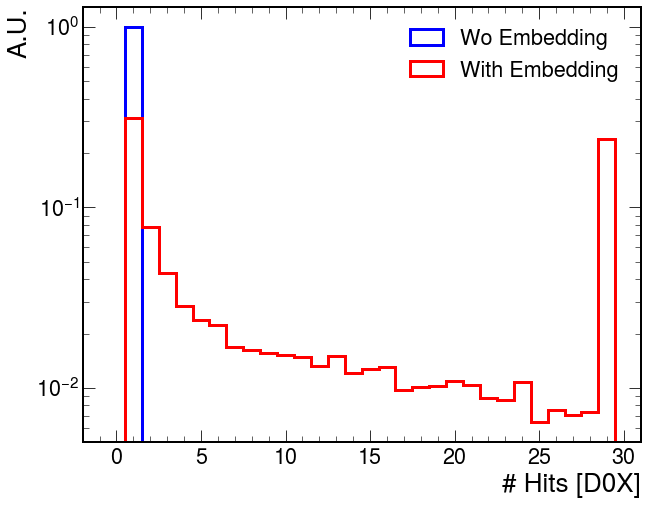

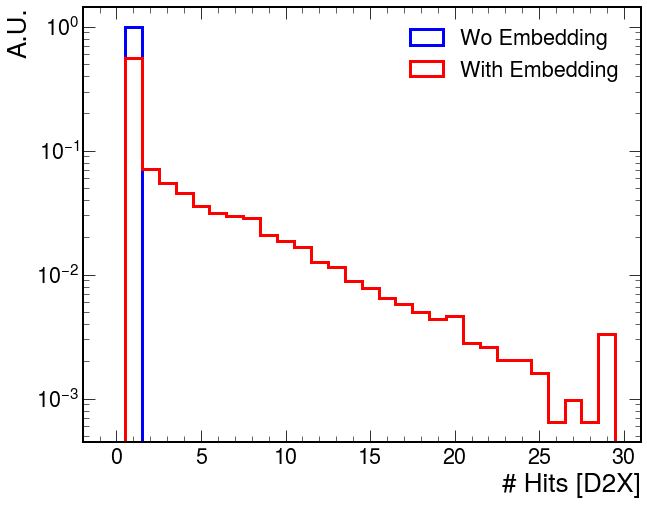

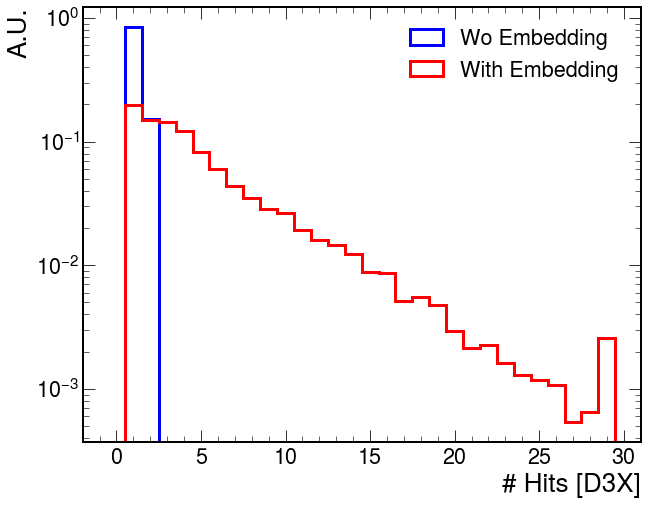

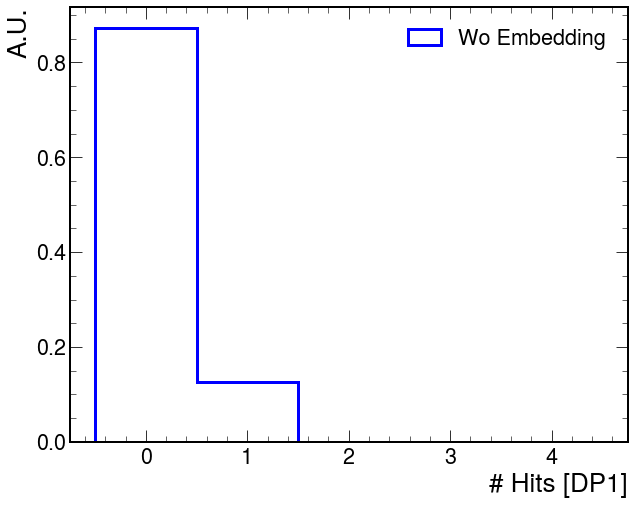

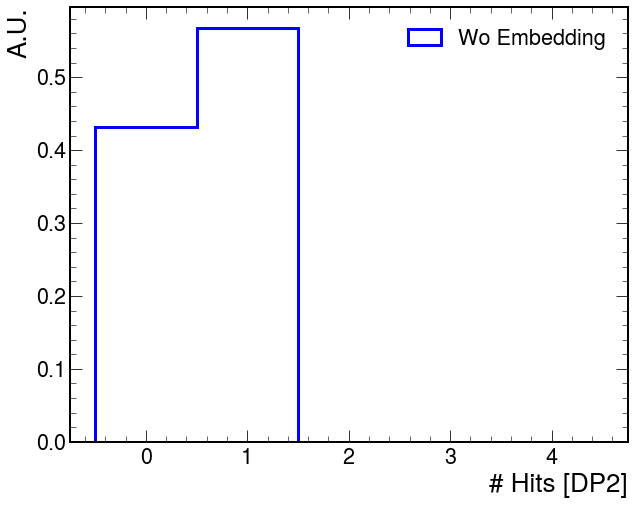

In [7]:
fig = plt.figure(figsize=(10,8))
plt.hist(MyClip(events_woembed['n_hits'].d1, 0, 29), bins=30, range=(-0.5,29.5), density=True, histtype='step', color='blue', linewidth=3, label='Wo Embedding')
plt.hist(MyClip(events_wembed['n_hits'].d1, 0, 29), bins=30, range=(-0.5,29.5), density=True, histtype='step', color='red',linewidth=3, label='With Embedding')
#plt.xlim(0,40)
plt.xlabel("# Hits [D0X]")
plt.ylabel('A.U.')
plt.yscale('log')
plt.legend()
plt.savefig("plots/n_hits_D1X.png")

fig = plt.figure(figsize=(10,8))
plt.hist(MyClip(events_woembed['n_hits_DC16'], 0, 29), bins=30, range=(-0.5,29.5), density=True, histtype='step', color='blue', linewidth=3, label='Wo Embedding')
plt.hist(MyClip(events_wembed['n_hits_DC16'], 0, 29), bins=30, range=(-0.5,29.5), density=True, histtype='step', color='red',linewidth=3, label='With Embedding')
#plt.xlim(0,40)
plt.xlabel("# Hits [D2X]")
plt.ylabel('A.U.')
plt.yscale('log')
plt.legend()
plt.show()
plt.savefig("plots/n_hits_D2X.png")
plt.close()

fig = plt.figure(figsize=(10,8))
plt.hist(MyClip(events_woembed['n_hits'].d3, 0, 29), bins=30, range=(-0.5,29.5), density=True, histtype='step', color='blue', linewidth=3, label='Wo Embedding')
plt.hist(MyClip(events_wembed['n_hits'].d3, 0, 29), bins=30, range=(-0.5,29.5), density=True, histtype='step', color='red',linewidth=3, label='With Embedding')
#plt.xlim(0,40)
plt.xlabel("# Hits [D3X]")
plt.ylabel('A.U.')
plt.yscale('log')
plt.legend()
plt.show()
plt.savefig("plots/n_hits_D2X.png")
plt.close()

fig = plt.figure(figsize=(10,8))
plt.hist(MyClip(events_woembed['n_hits'].dp1, 0, 4), bins=5, range=(-0.5,4.5), density=True, histtype='step', color='blue', linewidth=3, label='Wo Embedding')
#plt.hist(events_wembed['n_hits'].dp1, bins=5, range=(-0.5,4.5), density=True, histtype='step', color='red',linewidth=3, label='With Embedding')
#plt.xlim(0,40)
plt.xlabel("# Hits [DP1]")
plt.ylabel('A.U.')
#plt.yscale('log')
plt.legend()
plt.show()
plt.savefig("plots/n_hits_DP1.png")
plt.close()

fig = plt.figure(figsize=(10,8))
plt.hist(MyClip(events_woembed['n_hits'].dp2, 0, 4), bins=5, range=(-0.5,4.5), density=True, histtype='step', color='blue', linewidth=3, label='Wo Embedding')
#plt.hist(events_wembed['n_hits'].dp2, bins=5, range=(-0.5,4.5), density=True, histtype='step', color='red',linewidth=3, label='With Embedding')
#plt.xlim(0,40)
plt.xlabel("# Hits [DP2]")
plt.ylabel('A.U.')
#plt.yscale('log')
plt.legend()
plt.show()
plt.savefig("plots/n_hits_DP2.png")
plt.close()



plot some 2d hit count and total number of hits in one drift chamber distributions

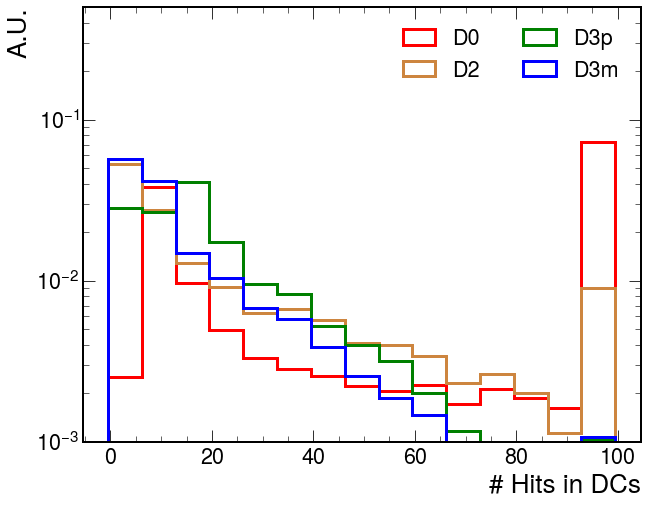

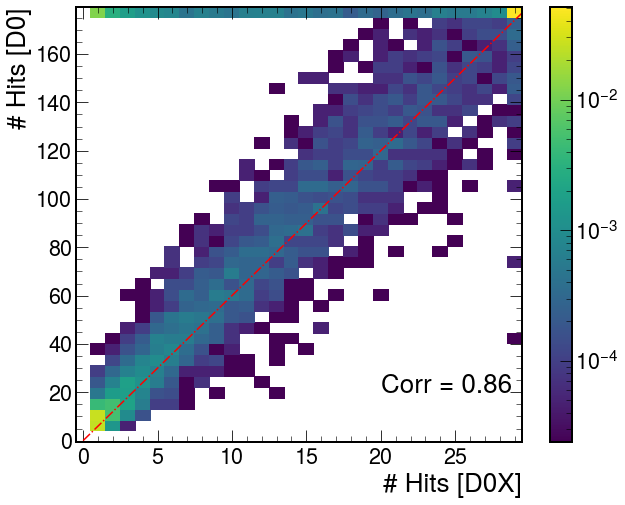

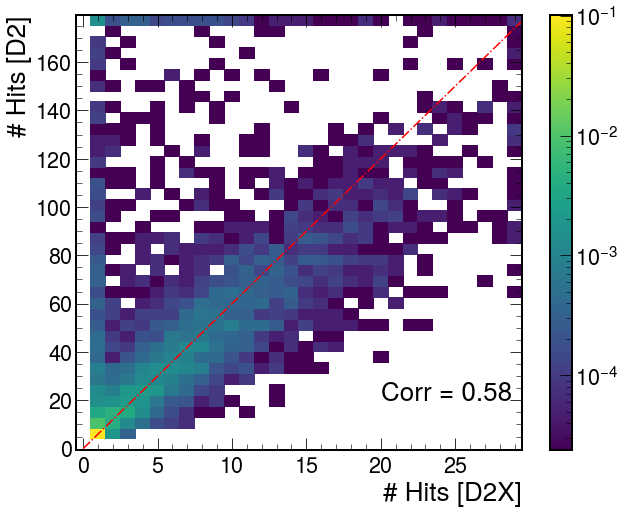

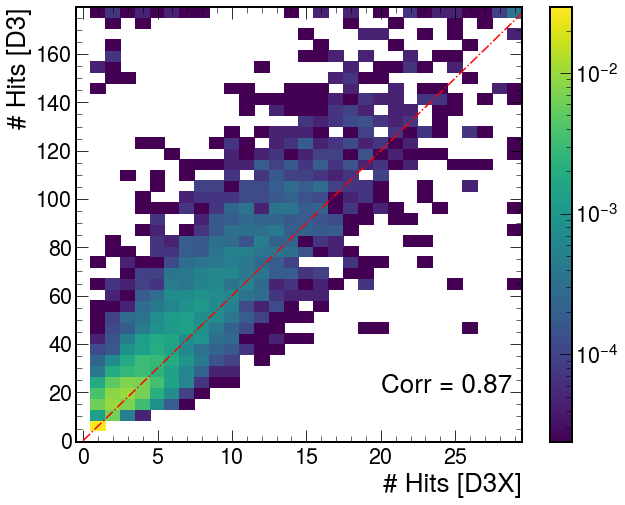

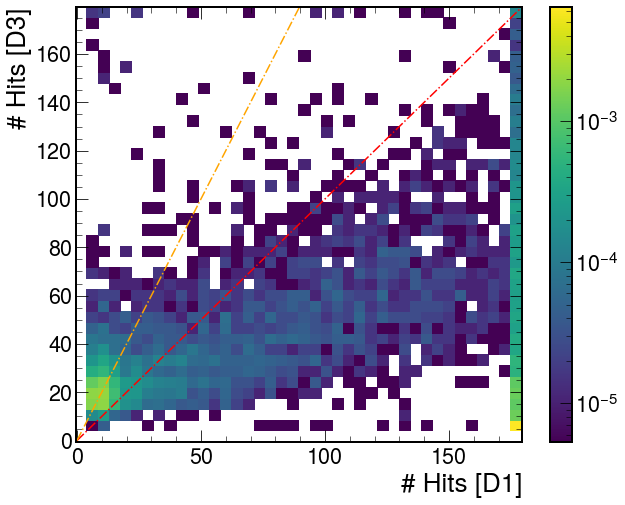

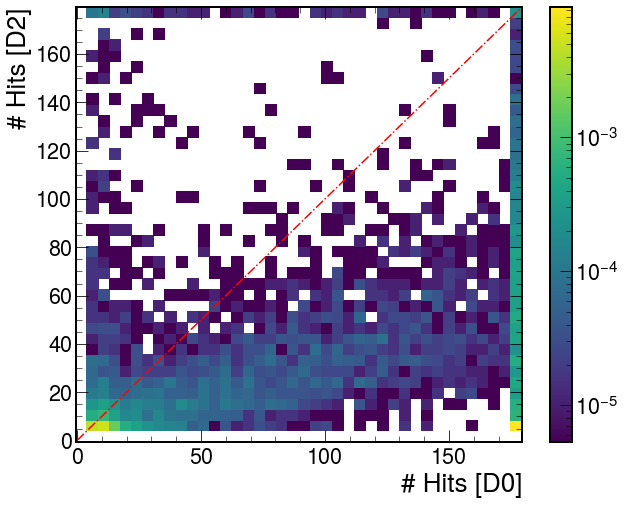

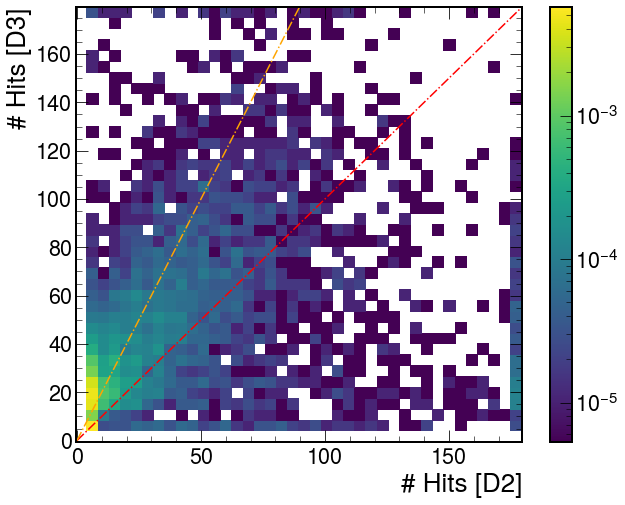

In [8]:
dc1bins = np.array([-0.5,0.5,1.5,3.5,6.5,10.5,15.5,25.5,40.5,70.5,150.5])
fig = plt.figure(figsize=(10,8))
plt.hist(MyClip(events_wembed['n_hits_D0'],0,99), bins=15, range=(-0.5,99.5), density=True, histtype='step', color='red',linewidth=3, label='D0')
#plt.hist(MyClip(events_wembed['n_hits_D1'],0,99), bins=15, range=(-0.5,99.5), density=True, histtype='step', color='magenta',linewidth=3, label='D1')
plt.hist(MyClip(events_wembed['n_hits_D2'],0,99), bins=15, range=(-0.5,99.5), density=True, histtype='step', color='peru',linewidth=3, label='D2')
plt.hist(MyClip(events_wembed['n_hits_D3p'],0,99), bins=15, range=(-0.5,99.5), density=True, histtype='step', color='green',linewidth=3, label='D3p')
plt.hist(MyClip(events_wembed['n_hits_D3m'],0,99), bins=15, range=(-0.5,99.5), density=True, histtype='step', color='blue',linewidth=3, label='D3m')
plt.ylim(1e-3,0.5)
plt.xlabel("# Hits in DCs")
plt.ylabel('A.U.')
plt.yscale('log')
plt.legend(ncol=2)
plt.savefig("plots/n_hits_D.png")


def nhits_expected(x,a=6):
    """
    given the number of hits in X, return the total number of 
    expected hits (about a factor of 6 since there are 6 layers).
    """
    return a*x

fig = plt.figure(figsize=(10,8))
plt.hist2d(MyClip(events_wembed['n_hits'].d1,0,29), MyClip(events_wembed['n_hits_D0'],0,179), bins=(30,40), range=[[-0.5,29.5],[-0.5,179.5]], norm=colors.LogNorm(), density=True)
#plt.xlim(0,40)
x = np.linspace(0, 30, 10)
plt.plot(x, nhits_expected(x), color='red', linestyle='-.')
plt.xlabel("# Hits [D0X]")
plt.ylabel('# Hits [D0]')
cor = corr(events_wembed['n_hits'].d1, events_wembed['n_hits_D0'])
plt.text(20, 20, f'Corr = {cor:.2f}')
#plt.yscale('log')
#plt.legend()
plt.colorbar()
plt.savefig("plots/nhits_d0x_vs_nhits_d0.png")

fig = plt.figure(figsize=(10,8))
plt.hist2d(MyClip(events_wembed['n_hits_DC16'], 0, 29), MyClip(events_wembed['n_hits_D2'], 0, 179), bins=(30,40), range=[[-0.5,29.5],[-0.5,179.5]], label='With Embedding', norm=colors.LogNorm(), density=True)
#plt.xlim(0,40)
x = np.linspace(0, 30, 10)
plt.plot(x, nhits_expected(x), color='red', linestyle='-.')
plt.xlabel("# Hits [D2X]")
plt.ylabel('# Hits [D2]')
#plt.yscale('log')
cor = corr(events_wembed['n_hits_DC16'], events_wembed['n_hits_D2'])
plt.text(20, 20, f'Corr = {cor:.2f}')
#plt.legend()
plt.colorbar()
plt.savefig("plots/nhits_d2x_vs_nhits_d2.png")


fig = plt.figure(figsize=(10,8))
plt.hist2d(MyClip(events_wembed['n_hits'].d3, 0, 29), MyClip(events_wembed['n_hits_D3p']+events_wembed['n_hits_D3m'], 0, 179), bins=(30,40), range=[[-0.5,29.5],[-0.5,179.5]], label='With Embedding', norm=colors.LogNorm(), density=True)
#plt.xlim(0,40)
x = np.linspace(0, 30, 10)
plt.plot(x, nhits_expected(x), color='red', linestyle='-.')
plt.xlabel("# Hits [D3X]")
plt.ylabel('# Hits [D3]')
cor = corr(events_wembed['n_hits'].d3, events_wembed['n_hits_D3p']+events_wembed['n_hits_D3m'])
plt.text(20, 20, f'Corr = {cor:.2f}')
#plt.yscale('log')
#plt.legend()
plt.colorbar()
plt.savefig("plots/nhits_d3x_vs_nhits_d3.png")

fig = plt.figure(figsize=(10,8))
plt.hist2d(MyClip(events_wembed['n_hits_D0'], 0, 179), MyClip(events_wembed['n_hits_D3p']+events_wembed['n_hits_D3m'], 0, 179), bins=(40,40), range=[[-0.5,179.5],[-0.5,179.5]], norm=colors.LogNorm(), density=True)
#plt.xlim(0,40)
x = np.linspace(0, 200, 20)
plt.plot(x, nhits_expected(x,1), color='red', linestyle='-.')
plt.plot(x, nhits_expected(x,2), color='orange', linestyle='-.')
plt.xlabel("# Hits [D1]")
plt.ylabel('# Hits [D3]')
#plt.yscale('log')
#plt.legend()
plt.colorbar()
plt.savefig("plots/nhits_d0_vs_nhits_d3.png")

fig = plt.figure(figsize=(10,8))
plt.hist2d(MyClip(events_wembed['n_hits_D0'], 0, 179), MyClip(events_wembed['n_hits_D2'], 0, 179), bins=(40,40), range=[[-0.5,179.5],[-0.5,179.5]], norm=colors.LogNorm(), density=True)
#plt.xlim(0,40)
x = np.linspace(0, 200, 20)
plt.plot(x, nhits_expected(x,1), color='red', linestyle='-.')
plt.xlabel("# Hits [D0]")
plt.ylabel('# Hits [D2]')
#plt.yscale('log')
#plt.legend()
plt.colorbar()
plt.savefig("plots/nhits_d0_vs_nhits_d2.png")

fig = plt.figure(figsize=(10,8))
plt.hist2d(MyClip(events_wembed['n_hits_D2'], 0, 179), MyClip(events_wembed['n_hits_D3p']+events_wembed['n_hits_D3m'], 0, 179), bins=(40,40), range=[[-0.5,179.5],[-0.5,179.5]], norm=colors.LogNorm(), density=True)
#plt.xlim(0,40)
x = np.linspace(0, 200, 20)
plt.plot(x, nhits_expected(x,1), color='red', linestyle='-.')
plt.plot(x, nhits_expected(x,2), color='orange', linestyle='-.')
plt.xlabel("# Hits [D2]")
plt.ylabel('# Hits [D3]')
#plt.yscale('log')
#plt.legend()
plt.colorbar()
plt.savefig("plots/nhits_d2_vs_nhits_d3.png")



Investigate the events with 1hit in D0X

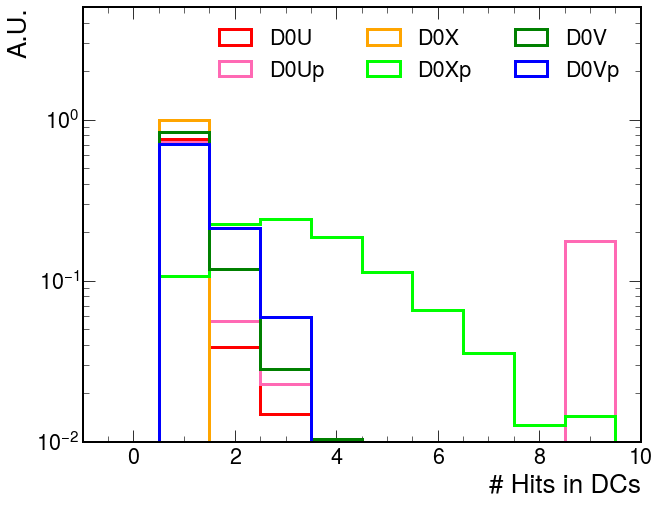

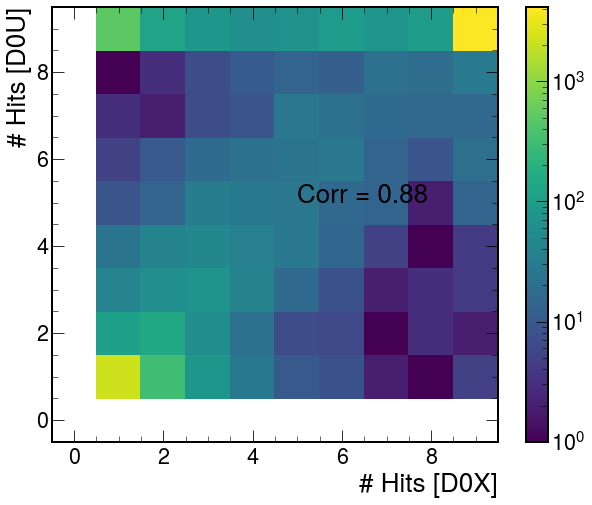

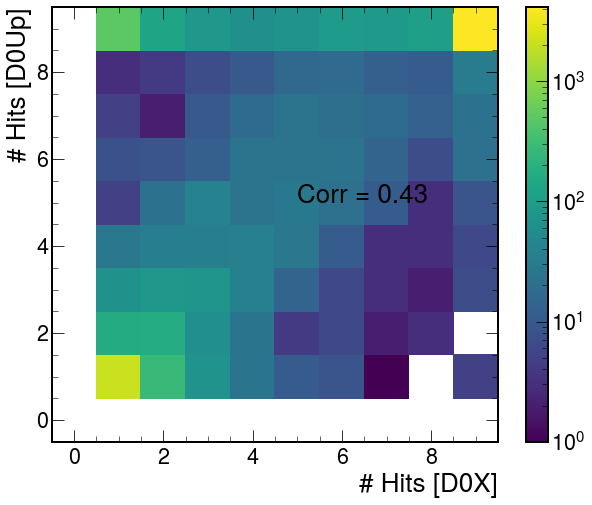

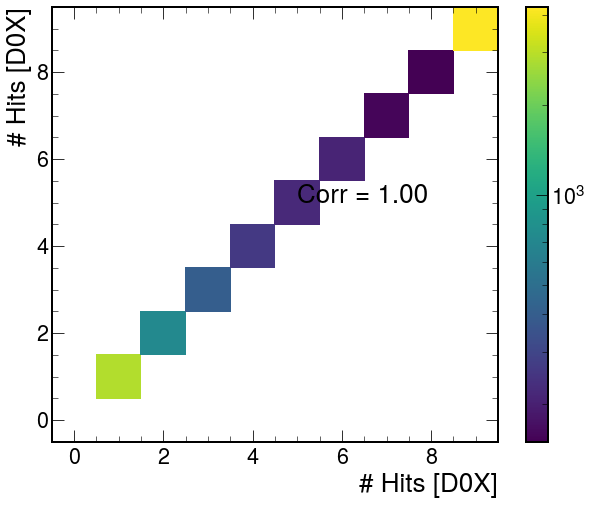

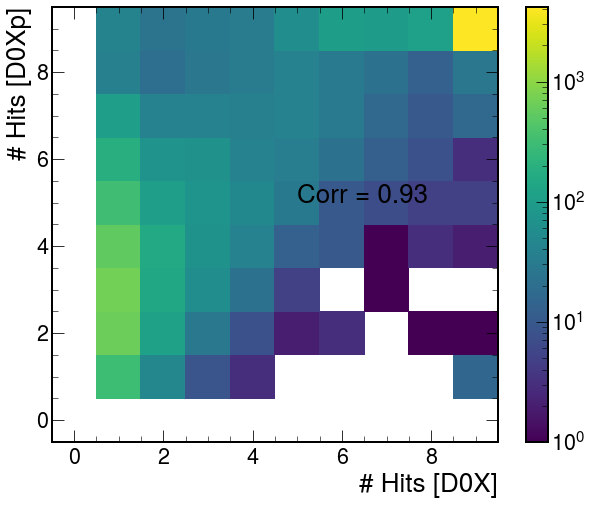

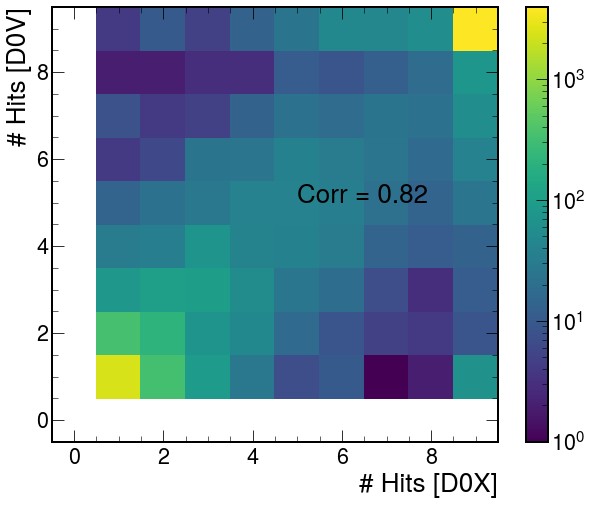

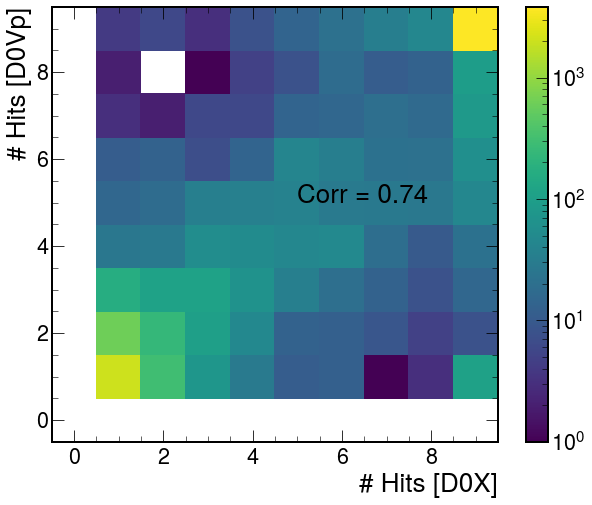

In [9]:
mylabels = {1: 'D0U', 2: 'D0Up', 3:'D0X', 4:'D0Xp', 5: 'D0V', 6: 'D0Vp'}
mycolors = {1: 'red', 2: 'hotpink', 3: 'orange', 4: 'lime', 5: 'green', 6: 'blue'}


fig = plt.figure(figsize=(10,8))
for i in range(1,7):
    plt.hist(MyClip(events_wembed[f'n_hits_DC{i}'][events_wembed['n_hits'].d1==1],0,9), bins=10, range=(-0.5,9.5), density=True, histtype='step', color=mycolors[i],linewidth=3, label=mylabels[i])
plt.xlabel("# Hits in DCs")
plt.ylabel('A.U.')
plt.yscale('log')
plt.ylim(1e-2,5)
plt.legend(ncol=3)
plt.savefig("plots/n_hits_D.png")

for i in range(1,7):
    fig = plt.figure(figsize=(10,8))
    plt.hist2d(MyClip(events_wembed[f'n_hits_DC3'], 0, 9), MyClip(events_wembed[f'n_hits_DC{i}'], 0, 9), bins=(10,10), range=[[-0.5,9.5],[-0.5,9.5]], norm=colors.LogNorm())
    #plt.plot(x, nhits_expected(x,1), color='red', linestyle='-.')
    #plt.plot(x, nhits_expected(x,2), color='orange', linestyle='-.')
    plt.xlabel("# Hits [D0X]")
    plt.ylabel(f'# Hits [{mylabels[i]}]')
    cor = corr(events_wembed[f'n_hits_DC3'], events_wembed[f'n_hits_DC{i}'])
    plt.text(5, 5, f'Corr = {cor:.2f}')
    #plt.yscale('log')
    plt.colorbar()
    #plt.legend()
    plt.savefig(f"plots/nhits_d0X_vs_nhits_{mylabels[i]}.png")



plot the DP hit position

In [10]:
def GetDPHits(events, doDP1 = True, axis= 'x'):
    """
    get the DP1, DP2 hits x, y, coordinates 
    return a flatten array for plotting
    """
    assert axis in ['x', 'y'], "axis can only be either x or y"
    # get the DP hit coordinates for one axis in one dp plane
    if doDP1:
        idmax = 58
        idmin = 55
    else:
        idmax = 62
        idmin = 59
    hitids = events['hit'].detID
    dphits = ak.flatten(events['hit'][(hitids>=idmin) & (hitids<=idmax)][axis])
    
    return dphits


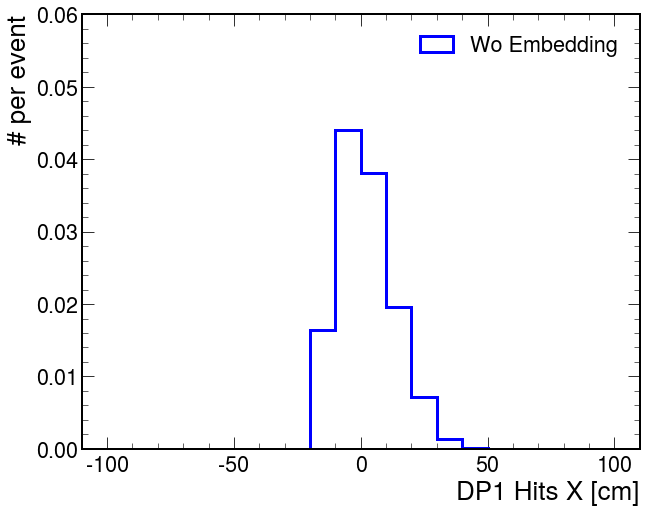

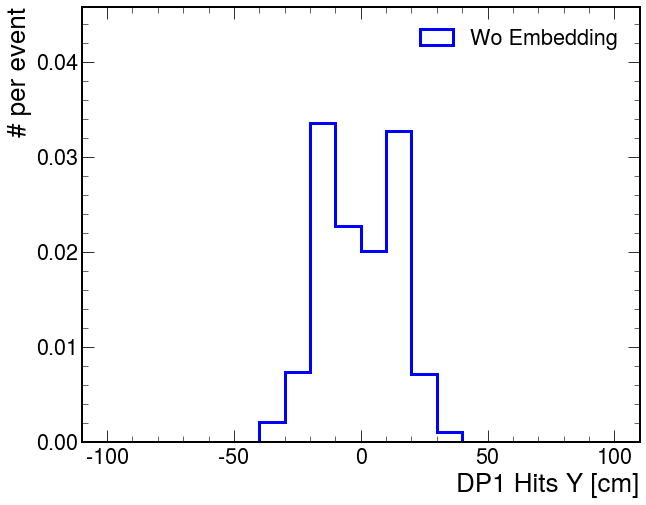

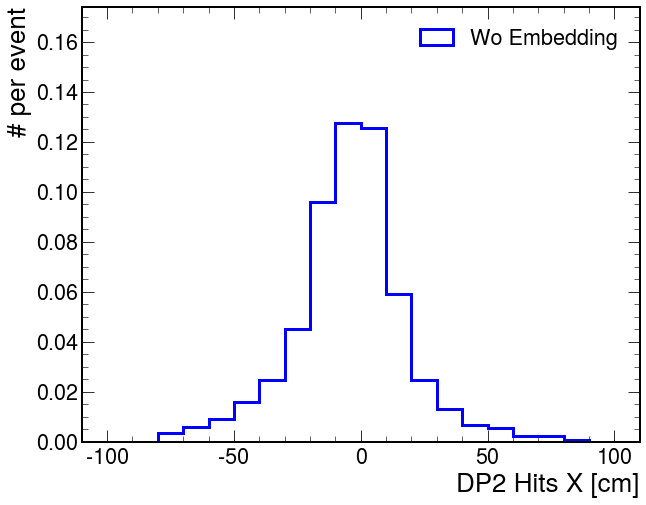

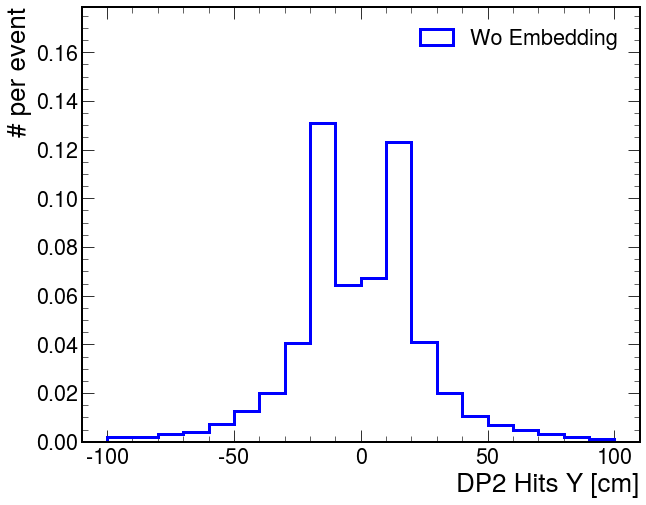

In [11]:
fig = plt.figure(figsize=(10,8))
dphits_x = GetDPHits(events_wembed, doDP1 = True, axis='x')
plt.hist(dphits_x, bins=20, range=(-100, 100), histtype='step', color='blue', linewidth=3, label='Wo Embedding', weights=ak.ones_like(dphits_x)*1.0/nevt_wembed)
#plt.xlim(0,40)
plt.xlabel("DP1 Hits X [cm]")
plt.ylabel('# per event')
#plt.yscale('log')
plt.legend()
plt.ylim(0,plt.ylim()[1]*1.3)
plt.show()
plt.savefig("plots/dp1_hit_x.png")
plt.close()

fig = plt.figure(figsize=(10,8))
dphits_y = GetDPHits(events_wembed, doDP1 = True, axis='y')
plt.hist(dphits_y, bins=20, range=(-100, 100), histtype='step', color='blue', linewidth=3, label='Wo Embedding', weights=ak.ones_like(dphits_y)*1.0/nevt_wembed)
#plt.xlim(0,40)
plt.xlabel("DP1 Hits Y [cm]")
plt.ylabel('# per event')
#plt.yscale('log')
plt.legend()
plt.ylim(0,plt.ylim()[1]*1.3)
plt.show()
plt.savefig("plots/dp1_hit_y.png")
plt.close()

fig = plt.figure(figsize=(10,8))
dphits_x = GetDPHits(events_wembed, doDP1 = False, axis='x')
plt.hist(dphits_x, bins=20, range=(-100, 100), histtype='step', color='blue', linewidth=3, label='Wo Embedding', weights=ak.ones_like(dphits_x)*1.0/nevt_wembed)
#plt.xlim(0,40)
plt.xlabel("DP2 Hits X [cm]")
plt.ylabel('# per event')
#plt.yscale('log')
plt.legend()
plt.ylim(0,plt.ylim()[1]*1.3)
plt.show()
plt.savefig("plots/dp2_hit_x.png")
plt.close()

fig = plt.figure(figsize=(10,8))
dphits_y = GetDPHits(events_wembed, doDP1 = False, axis='y')
plt.hist(dphits_y, bins=20, range=(-100, 100), histtype='step', color='blue', linewidth=3, label='Wo Embedding', weights=ak.ones_like(dphits_y)*1.0/nevt_wembed)
#plt.xlim(0,40)
plt.xlabel("DP2 Hits Y [cm]")
plt.ylabel('# per event')
#plt.yscale('log')
plt.legend()
plt.ylim(0,plt.ylim()[1]*1.3)
plt.show()
plt.savefig("plots/dp2_hit_y.png")
plt.close()

### Only look at events with nhits < 100

In [12]:
def SelectEvents(events):
    selection = (events['n_hits_D0'] <= 100) & \
                (events['n_hits_D1'] <= 100) & \
                (events['n_hits_D2'] <= 100) & \
                (events['n_hits_D3p'] <= 100) & \
                (events['n_hits_D3m'] <= 100)
    nevts = len(events)
    events_selected = events[selection]
    nevts_selected = len(events_selected)

    print("total events: ", nevts)
    print(f"total events after selection: {nevts_selected}, rato is {nevts_selected/nevts:.2f}")
    return events_selected


In [13]:
events_wembed = SelectEvents(events_wembed)
events_woembed = SelectEvents(events_woembed)
events_wembed_oldtrk = SelectEvents(events_wembed_oldtrk)
events_woembed_oldtrk = SelectEvents(events_woembed_oldtrk)

total events:  9270
total events after selection: 4002, rato is 0.43
total events:  9270
total events after selection: 9270, rato is 1.00
total events:  9320
total events after selection: 4022, rato is 0.43
total events:  9320
total events after selection: 9320, rato is 1.00


### compare the track momentum distribution with and without embedding

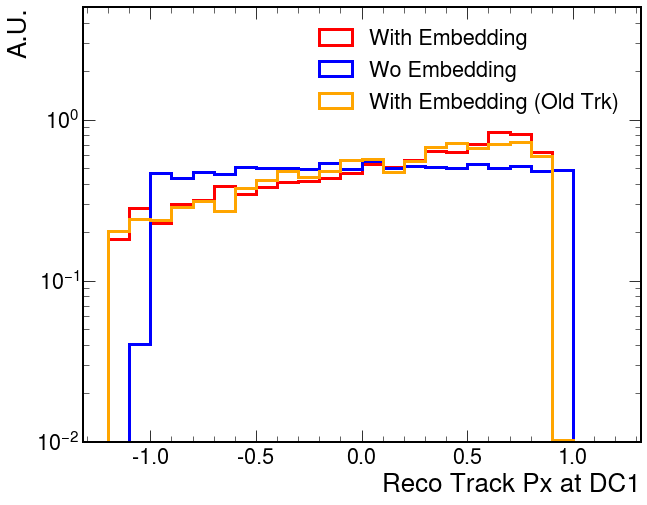

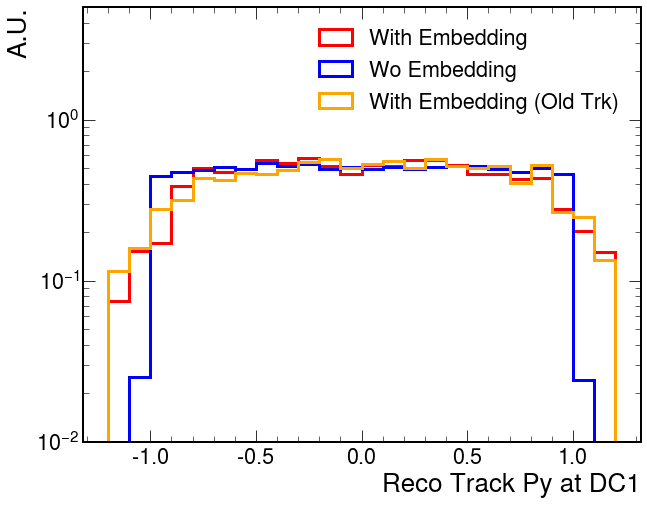

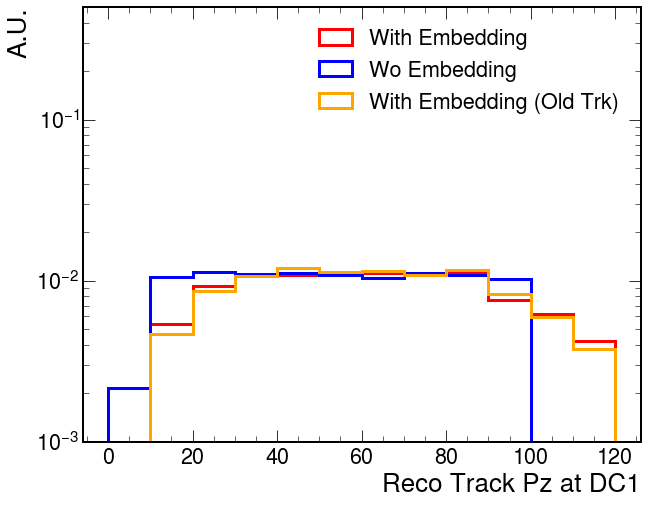

In [14]:
fig = plt.figure(figsize=(10,8))
plt.hist(ak.flatten(events_wembed['track'].px[:]), bins=24, range=(-1.2,1.2), density=True, histtype='step', color='red',linewidth=3, label='With Embedding')
plt.hist(ak.flatten(events_woembed['track'].px[:]), bins=24, range=(-1.2,1.2), density=True, histtype='step', color='blue', linewidth=3, label='Wo Embedding')
plt.hist(ak.flatten(events_wembed_oldtrk['track'].px[:]), bins=24, range=(-1.2,1.2), density=True, histtype='step', color='orange',linewidth=3, label='With Embedding (Old Trk)')
#plt.hist(ak.flatten(events_woembed_oldtrk['track'].px[:]), bins=24, range=(-1.2,1.2), density=True, histtype='step', color='green', linewidth=3, label='Wo Embedding (Old Trk)')
#plt.xlim(0,40)
plt.ylim(0.01,5.0)
plt.xlabel("Reco Track Px at DC1")
plt.ylabel('A.U.')
plt.yscale('log')
plt.legend()
plt.savefig("plots/track_px_st1.png")

fig = plt.figure(figsize=(10,8))
plt.hist(ak.flatten(events_wembed['track'].py[:]), bins=24, range=(-1.2,1.2), density=True, histtype='step', color='red',linewidth=3, label='With Embedding')
plt.hist(ak.flatten(events_woembed['track'].py[:]), bins=24, range=(-1.2,1.2), density=True, histtype='step', color='blue', linewidth=3, label='Wo Embedding')
plt.hist(ak.flatten(events_wembed_oldtrk['track'].py[:]), bins=24, range=(-1.2,1.2), density=True, histtype='step', color='orange',linewidth=3, label='With Embedding (Old Trk)')
#plt.hist(ak.flatten(events_woembed_oldtrk['track'].px[:]), bins=24, range=(-1.2,1.2), density=True, histtype='step', color='green', linewidth=3, label='Wo Embedding (Old Trk)')
#plt.xlim(0,40)
plt.ylim(0.01,5.0)
plt.xlabel("Reco Track Py at DC1")
plt.ylabel('A.U.')
plt.yscale('log')
plt.legend()
plt.savefig("plots/track_py_st1.png")

fig = plt.figure(figsize=(10,8))
plt.hist(ak.flatten(events_wembed['track'].pz[:]), bins=12, range=(0,120), density=True, histtype='step', color='red',linewidth=3, label='With Embedding')
plt.hist(ak.flatten(events_woembed['track'].pz[:]), bins=12, range=(0,120), density=True, histtype='step', color='blue', linewidth=3, label='Wo Embedding')
plt.hist(ak.flatten(events_wembed_oldtrk['track'].pz[:]), bins=12, range=(0,120), density=True, histtype='step', color='orange',linewidth=3, label='With Embedding (Old Trk)')
#plt.hist(ak.flatten(events_woembed_oldtrk['track'].pz[:]), bins=12, range=(0,120), density=True, histtype='step', color='green', linewidth=3, label='Wo Embedding (Old Trk)')
#plt.xlim(0,40)
plt.ylim(1e-3,0.5)
plt.xlabel("Reco Track Pz at DC1")
plt.ylabel('A.U.')
plt.yscale('log')
plt.legend()
plt.savefig("plots/track_pz_st1.png")



### compare the track reconstruction efficiency with and without embedding

In [15]:
def calculateEff(events, pname='pz'):
    assert pname in ['px','py', 'pz', 'd0', 'd0x'], "pname must be among ['px', 'py', 'pz', 'd0', 'd0x']"
    
    ranges = {'pz': (0,100),
              'px': (-1.0, 1.0),
              'py': (-1.0, 1.0)}
    bins = {}
    bins['d0'] = np.array([-0.5,0.5,1.5,3.5,6.5,10.5,15.5,25.5,40.5,70.5,150.5])
    bins['d0x'] = np.array([-0.5,0.5,1.5,3.5,6.5,10.5,15.5,25.5,40.5,70.5,150.5])
  
    isMatched = events['truthtrack'].rec_id[...,0]!=-1
    
    if pname in ['px', 'py', 'pz']:
        p_matched = ak.to_numpy(ak.flatten(events['truthtrack'][isMatched][pname]))
        p_total = ak.to_numpy(ak.flatten(events['truthtrack'][pname]))
        nreco, bin_edges = np.histogram(p_matched, bins=10, range=ranges[pname])
        ngen, bin_edges  = np.histogram(p_total, bins=10, range=ranges[pname])
    else:
        if pname == 'd0':
            p_matched = ak.to_numpy(events['n_hits_D0'][isMatched])
            p_total = ak.to_numpy(events['n_hits_D0'])
        else:
            p_matched = ak.to_numpy(events['n_hits_DC3'][isMatched])
            p_total = ak.to_numpy(events['n_hits_DC3'])
        nreco, bin_edges = np.histogram(p_matched, bins=bins[pname])
        ngen, bin_edges  = np.histogram(p_total, bins=bins[pname])
          
    ratios = nreco/ngen 
    # binomal uncertainties
    uncs = np.sqrt(ratios*(1-ratios)/ngen)

    return ratios, uncs, bin_edges
    

<ipython-input-15-c65131b54166>:28: RuntimeWarning: invalid value encountered in true_divide
  ratios = nreco/ngen


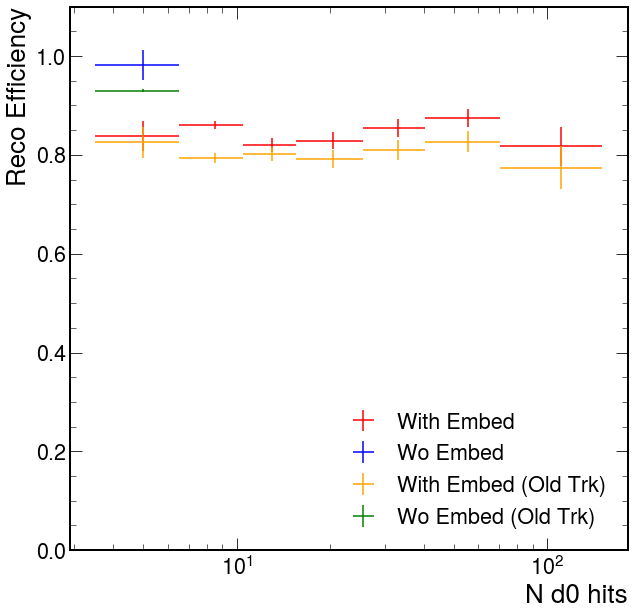

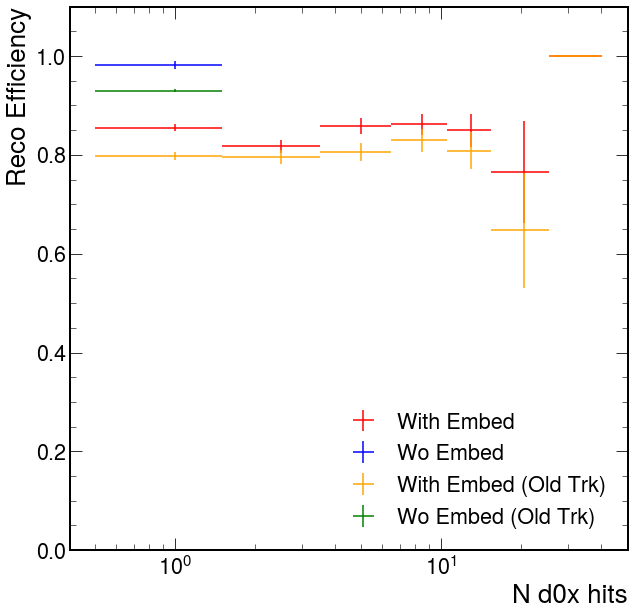

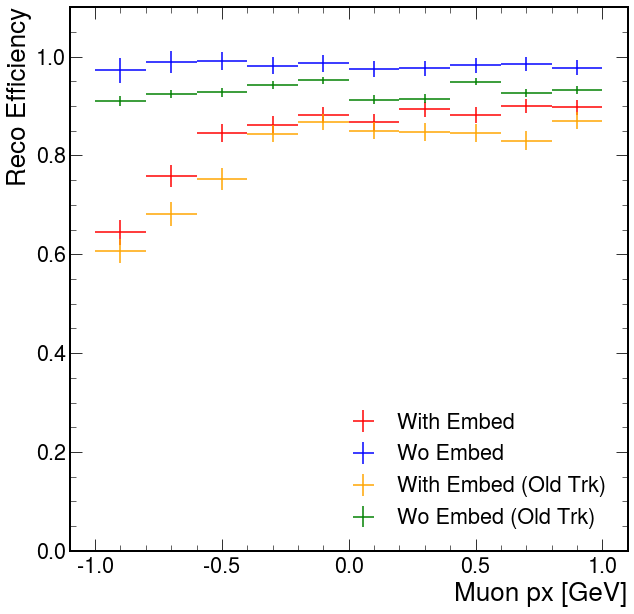

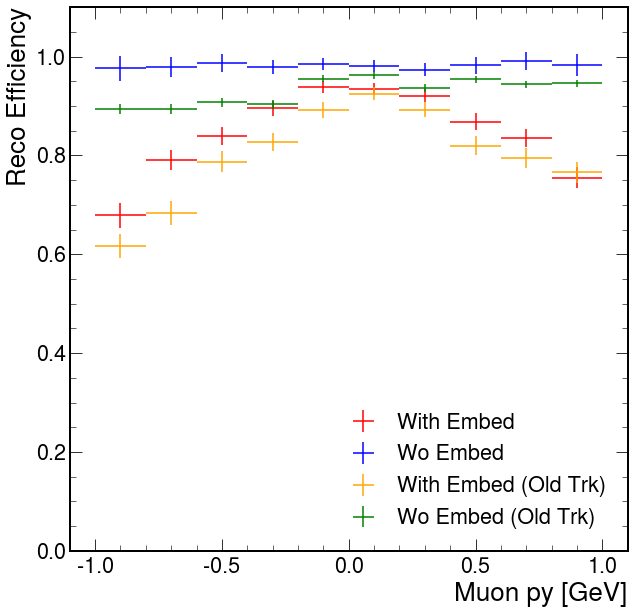

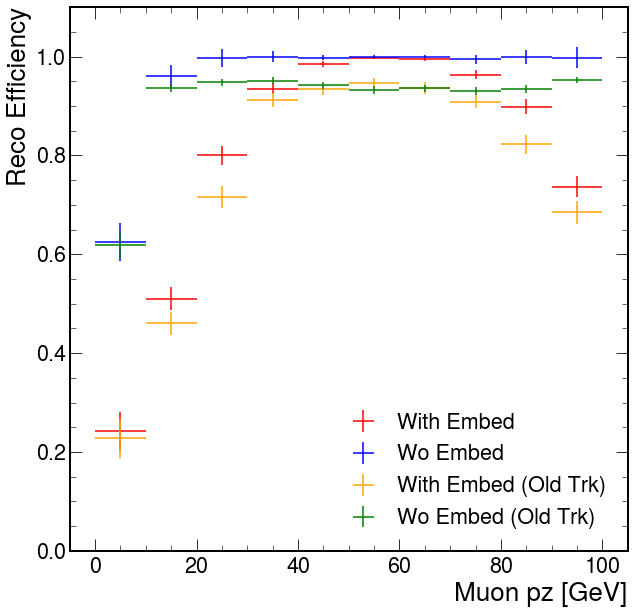

In [16]:
for pname in ['d0','d0x', 'px', 'py', 'pz']:
    eff_wembed, unc_wembed, bin_edges = calculateEff(events_wembed, pname)
    eff_woembed, unc_woembed, bin_edges = calculateEff(events_woembed, pname)
    eff_wembed_oldtrk, unc_wembed_oldtrk, bin_edges = calculateEff(events_wembed_oldtrk, pname)
    eff_woembed_oldtrk, unc_woembed_oldtrk, bin_edges = calculateEff(events_woembed_oldtrk, pname)

    x_centers = (bin_edges[:-1] + bin_edges[1:])/2.0
    x_errs = (bin_edges[1:] - bin_edges[:-1])/2.0


    plt.figure()
    plt.errorbar(x_centers, eff_wembed, unc_wembed, x_errs, label='With Embed', color='red', ls='none')
    plt.errorbar(x_centers, eff_woembed, unc_wembed, x_errs, label='Wo Embed', color='blue', ls='none')
    plt.errorbar(x_centers, eff_wembed_oldtrk, unc_wembed_oldtrk, x_errs, label='With Embed (Old Trk)', color='orange', ls='none')
    plt.errorbar(x_centers, eff_woembed_oldtrk, unc_woembed_oldtrk, x_errs, label='Wo Embed (Old Trk)', color='green', ls='none')
    #plt.xlim(0,100)
    plt.ylim(0.0,1.1)
    if pname in ['d0', 'd0x']:
        plt.xlabel(f'N {pname} hits')
        plt.xscale('log')
    else:
        plt.xlabel(f'Muon {pname} [GeV]')
    #plt.ylabel('<$E_{Cluster}$>/<$E_{Gen}$>')
    plt.ylabel('Reco Efficiency')
    plt.legend(loc='lower right')
    plt.savefig(f"plots/REco_Efficiency_{pname}.png")


### Compare the resolutions/diffs without and without embedding

current setup probably only works for the gun events where there is maximum 1 truthtrack per event

Need to fix it to work on signal samples

In [17]:
def selectionMatched(events):
    """
    select the events that has matched reco tracks
    """
    return events[events['truthtrack'].rec_id[...,0]!=-1]

def getMatchedDiff(events, varname='px'):
    events_recoed = selectionMatched(events)
    
    track_reco = ak.flatten(events_recoed['track'][events_recoed['truthtrack'].rec_id][varname])
    track_truth = ak.flatten(events_recoed['truthtrack'][varname])
    
    return track_reco-track_truth

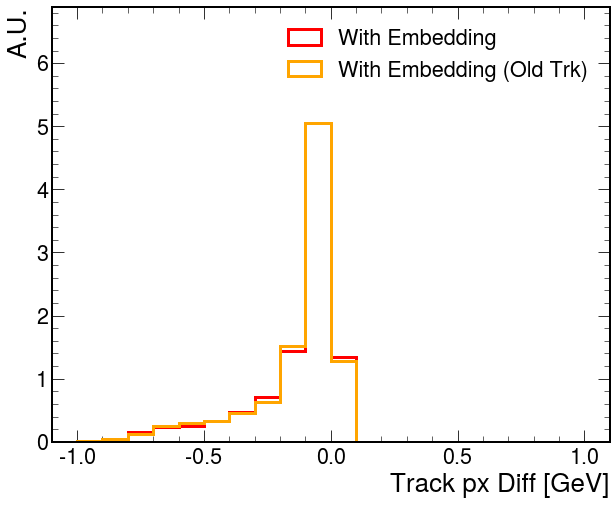

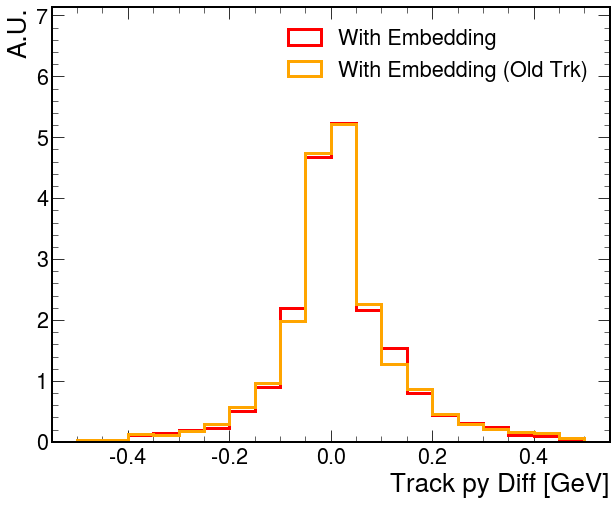

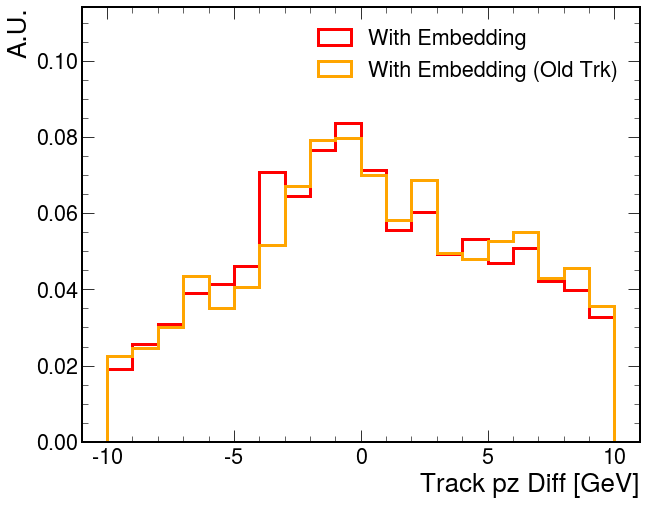

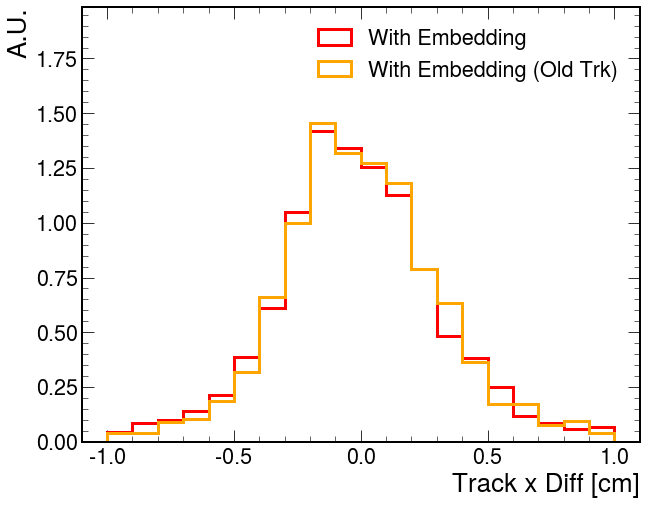

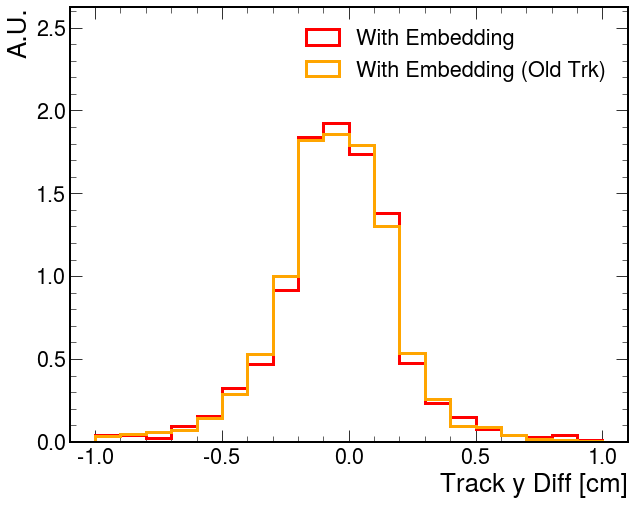

In [18]:
ranges = {
    'px': (-1.0, 1.0),
    'py': (-0.5, 0.5),
    'pz': (-10.0, 10.0),
    'x': (-1.0, 1.0),
    'y': (-1.0, 1.0),
}

units = {
    'px': 'GeV',
    'py': 'GeV',
    'pz': 'GeV',
    'x': 'cm',
    'y': 'cm',
}

for pname in ['px', 'py', 'pz', 'x', 'y']:
    fig = plt.figure(figsize=(10,8))
    plt.hist(getMatchedDiff(events_wembed, pname), bins=20, range=ranges[pname], density=True, histtype='step', color='red',linewidth=3, label='With Embedding')
    plt.hist(getMatchedDiff(events_wembed_oldtrk, pname), bins=20, range=ranges[pname], density=True, histtype='step', color='orange',linewidth=3, label='With Embedding (Old Trk)')
    plt.ylim(0,plt.ylim()[1]*1.3)
    plt.xlabel(f"Track {pname} Diff [{units[pname]}]")
    plt.ylabel('A.U.')
    #plt.yscale('log')
    plt.legend()
    plt.savefig(f"plots/track_{pname}_st1.png")
    
    

### counting the fake tracks

In [19]:
def CountFakes(events, prefix=""):
    n_truth_total = ak.count(events['truthtrack'].px)
    n_truth_recoed = ak.count(selectionMatched(events)['truthtrack'].px)
    n_recoed = ak.count(events['track'].px)
    
    print(f"{prefix}: total truth tracks generated: ", n_truth_total)
    print(f"{prefix}: total truth tracks matched to reco: ", n_truth_recoed)
    print(f"{prefix}: total reco-ed tracks: ", n_recoed)
    print(f"{prefix}: reco efficiency: ", n_truth_recoed/n_truth_total)
    print(f"{prefix}: fakes:", n_recoed-n_truth_recoed)


In [20]:
CountFakes(events_wembed, "With embedding")
print()
print("*"*5)
CountFakes(events_woembed, "Without embedding")
print()
print("*"*5)
CountFakes(events_wembed_oldtrk, "With embedding (Old Tracking)")
print()
print("*"*5)
CountFakes(events_woembed_oldtrk, "Without embedding (Old Tracking)")


With embedding: total truth tracks generated:  4002
With embedding: total truth tracks matched to reco:  3391
With embedding: total reco-ed tracks:  3418
With embedding: reco efficiency:  0.8473263368315842
With embedding: fakes: 27

*****
Without embedding: total truth tracks generated:  9270
Without embedding: total truth tracks matched to reco:  9101
Without embedding: total reco-ed tracks:  9101
Without embedding: reco efficiency:  0.9817691477885653
Without embedding: fakes: 0

*****
With embedding (Old Tracking): total truth tracks generated:  4022
With embedding (Old Tracking): total truth tracks matched to reco:  3217
With embedding (Old Tracking): total reco-ed tracks:  3242
With embedding (Old Tracking): reco efficiency:  0.7998508204873197
With embedding (Old Tracking): fakes: 25

*****
Without embedding (Old Tracking): total truth tracks generated:  9320
Without embedding (Old Tracking): total truth tracks matched to reco:  8664
Without embedding (Old Tracking): total reco-

## Compare the data embedding with simulation embedding

In [21]:
filename = "/seaquest/users/yfeng/DarkQuest/DarkQuest/e1039-analysis/SimHits/macro/simembedding/output.root"
events_wembed_sim = getData(filename)

select only the events with DC hits <= 100

In [22]:
events_wembed_sim = SelectEvents(events_wembed_sim)

total events:  3522
total events after selection: 3522, rato is 1.00


In [23]:
nevt_wembed_sim = len(events_wembed_sim)

compare the hits in DCs and DPs

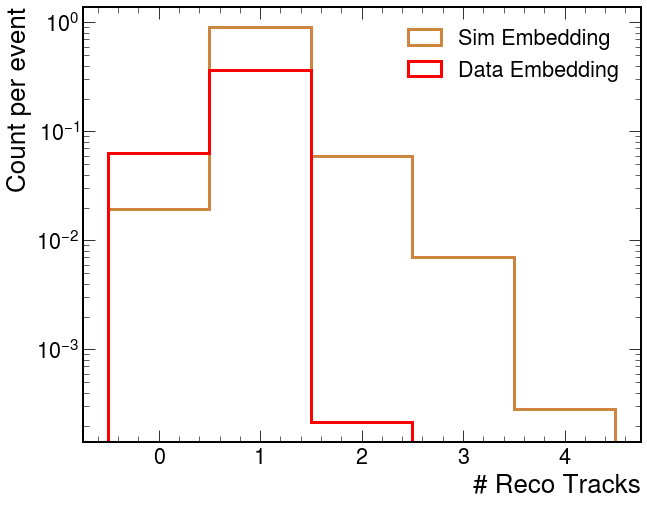

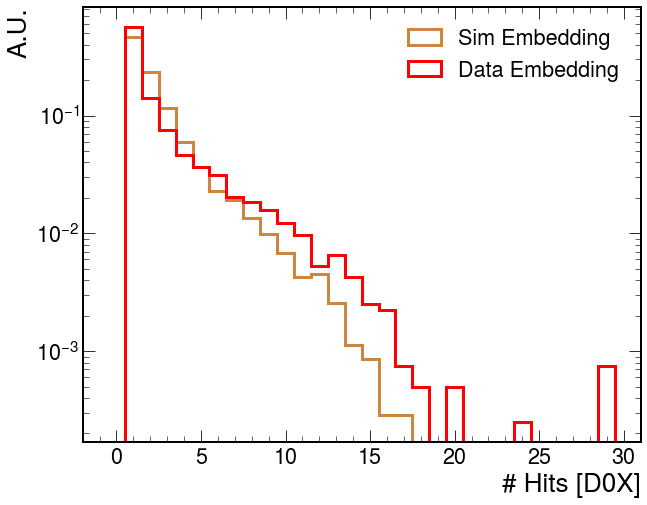

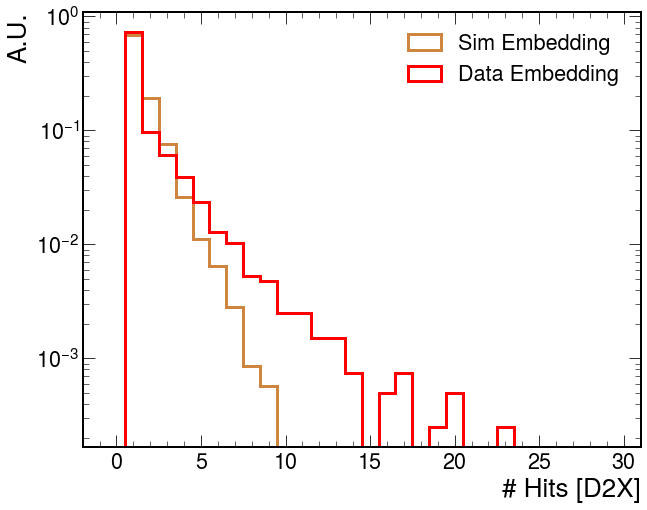

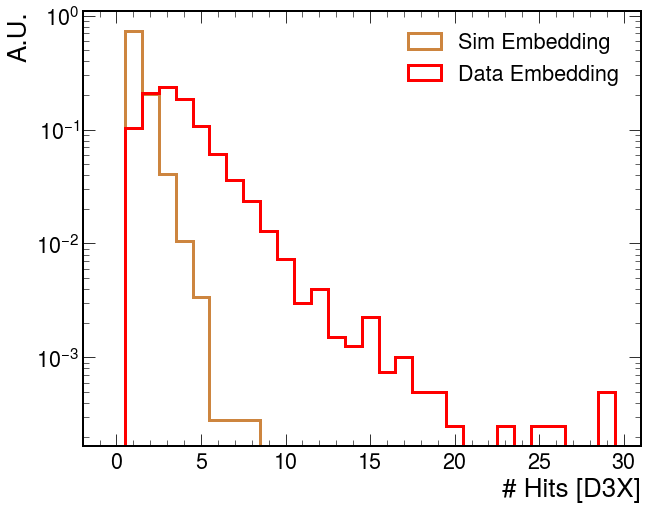

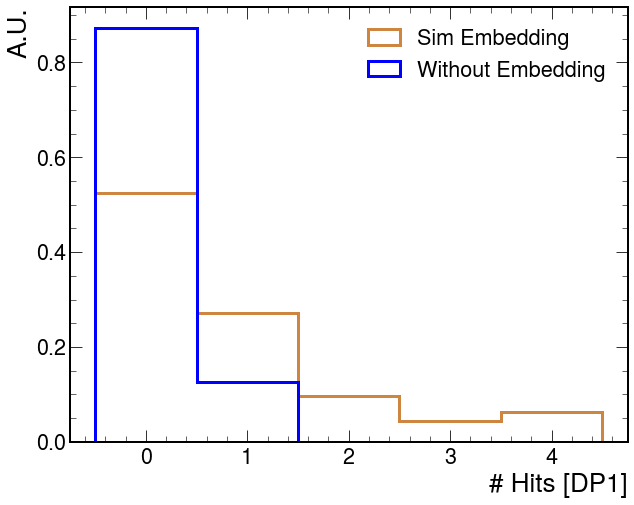

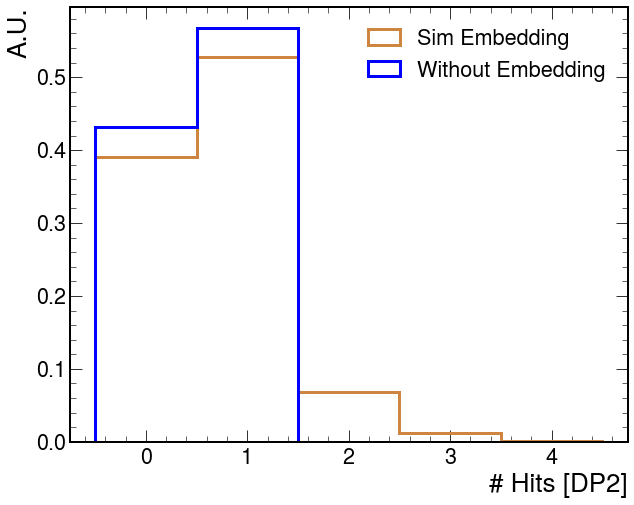

In [24]:
fig = plt.figure(figsize=(10,8))
plt.hist(MyClip(events_wembed_sim['ntrack'].n_tracks, 0, 4), bins=5, density=False, range=(-0.5,4.5), histtype='step', color='peru', linewidth=3, label='Sim Embedding', weights=ak.ones_like(events_wembed_sim['ntrack'].n_tracks)*1.0/nevt_wembed_sim)
plt.hist(MyClip(events_wembed['ntrack'].n_tracks, 0, 4), bins=5, density=False, range=(-0.5,4.5), histtype='step', color='red',linewidth=3, label='Data Embedding', weights=ak.ones_like(events_wembed['ntrack'].n_tracks)*1.0/nevt_wembed)
#plt.xlim(0,40)
plt.xlabel("# Reco Tracks")
plt.ylabel('Count per event')
plt.yscale('log')
plt.legend()
plt.savefig("plots/n_reco_tracks.png")

fig = plt.figure(figsize=(10,8))
plt.hist(MyClip(events_wembed_sim['n_hits'].d1, 0, 29), bins=30, density=True, range=(-0.5,29.5), histtype='step', color='peru', linewidth=3, label='Sim Embedding')
plt.hist(MyClip(events_wembed['n_hits'].d1, 0, 29), bins=30, density=True, range=(-0.5,29.5), histtype='step', color='red',linewidth=3, label='Data Embedding')
#plt.xlim(0,40)
plt.xlabel("# Hits [D0X]")
plt.ylabel('A.U.')
plt.yscale('log')
plt.legend()
plt.savefig("plots/n_hits_D0X.png")

fig = plt.figure(figsize=(10,8))
plt.hist(MyClip(events_wembed_sim['n_hits_DC16'], 0, 29), bins=30, range=(-0.5,29.5), density=True, histtype='step', color='peru', linewidth=3, label='Sim Embedding')
plt.hist(MyClip(events_wembed['n_hits_DC16'], 0, 29), bins=30, range=(-0.5,29.5), density=True, histtype='step', color='red',linewidth=3, label='Data Embedding')
#plt.xlim(0,40)
plt.xlabel("# Hits [D2X]")
plt.ylabel('A.U.')
plt.yscale('log')
plt.legend()
plt.show()
plt.savefig("plots/n_hits_D2X.png")
plt.close()

fig = plt.figure(figsize=(10,8))
plt.hist(MyClip(events_wembed_sim['n_hits'].d3, 0, 29), bins=30, range=(-0.5,29.5), density=True, histtype='step', color='peru', linewidth=3, label='Sim Embedding')
plt.hist(MyClip(events_wembed['n_hits'].d3, 0, 29), bins=30, range=(-0.5,29.5), density=True, histtype='step', color='red',linewidth=3, label='Data Embedding')
#plt.xlim(0,40)
plt.xlabel("# Hits [D3X]")
plt.ylabel('A.U.')
plt.yscale('log')
plt.legend()
plt.show()
plt.savefig("plots/n_hits_D2X.png")
plt.close()

fig = plt.figure(figsize=(10,8))
plt.hist(MyClip(events_wembed_sim['n_hits'].dp1, 0, 4), bins=5, range=(-0.5,4.5), density=True, histtype='step', color='peru', linewidth=3, label='Sim Embedding')
plt.hist(MyClip(events_woembed['n_hits'].dp1, 0, 4), bins=5, range=(-0.5,4.5), density=True, histtype='step', color='blue',linewidth=3, label='Without Embedding')
#plt.xlim(0,40)
plt.xlabel("# Hits [DP1]")
plt.ylabel('A.U.')
#plt.yscale('log')
plt.legend()
plt.show()
plt.savefig("plots/n_hits_DP1.png")
plt.close()

fig = plt.figure(figsize=(10,8))
plt.hist(MyClip(events_wembed_sim['n_hits'].dp2, 0, 4), bins=5, range=(-0.5,4.5), density=True, histtype='step', color='peru', linewidth=3, label='Sim Embedding')
plt.hist(MyClip(events_woembed['n_hits'].dp2, 0, 4), bins=5, range=(-0.5,4.5), density=True, histtype='step', color='blue',linewidth=3, label='Without Embedding')
#plt.xlim(0,40)
plt.xlabel("# Hits [DP2]")
plt.ylabel('A.U.')
#plt.yscale('log')
plt.legend()
plt.show()
plt.savefig("plots/n_hits_DP2.png")
plt.close()

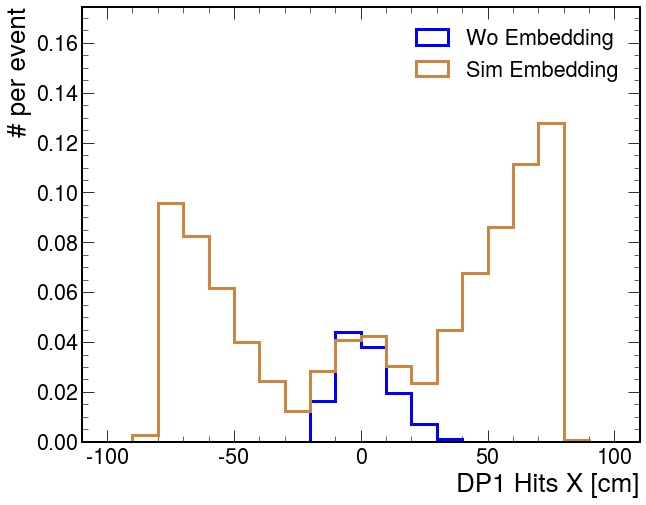

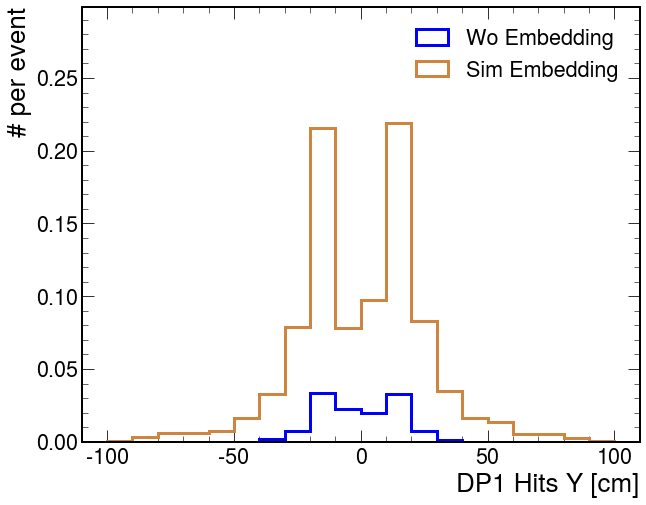

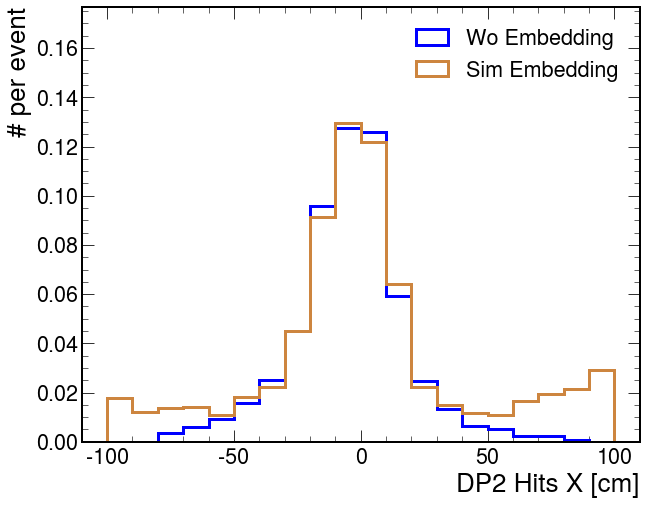

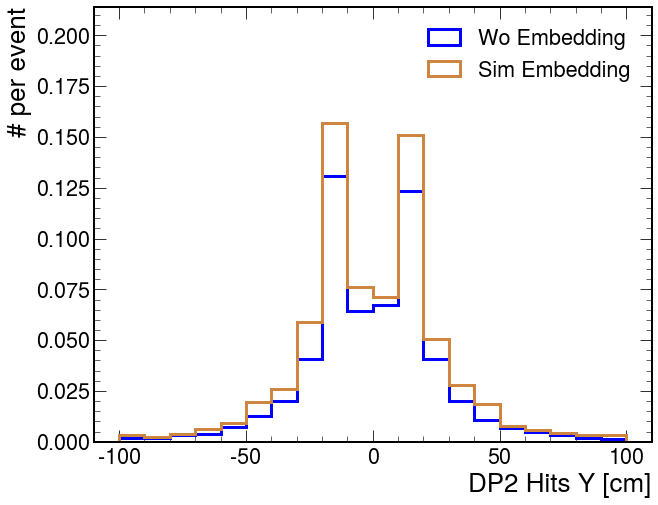

In [25]:
fig = plt.figure(figsize=(10,8))
dphits_x = GetDPHits(events_woembed, doDP1 = True, axis='x')
dphits_x_sim = GetDPHits(events_wembed_sim, doDP1 = True, axis='x')
plt.hist(MyClip(dphits_x, -99, 99), bins=20, range=(-100, 100), histtype='step', color='blue', linewidth=3, label='Wo Embedding', weights=ak.ones_like(dphits_x)*1.0/nevt_woembed)
plt.hist(MyClip(dphits_x_sim, -99, 99), bins=20, range=(-100, 100), histtype='step', color='peru', linewidth=3, label='Sim Embedding', weights=ak.ones_like(dphits_x_sim)*1.0/nevt_wembed_sim)
#plt.xlim(0,40)
plt.xlabel("DP1 Hits X [cm]")
plt.ylabel('# per event')
#plt.yscale('log')
plt.legend()
plt.ylim(0,plt.ylim()[1]*1.3)
plt.show()
plt.savefig("plots/dp1_hit_x.png")
plt.close()

fig = plt.figure(figsize=(10,8))
dphits_y = GetDPHits(events_woembed, doDP1 = True, axis='y')
dphits_y_sim = GetDPHits(events_wembed_sim, doDP1 = True, axis='y')
plt.hist(MyClip(dphits_y, -99, 99), bins=20, range=(-100, 100), histtype='step', color='blue', linewidth=3, label='Wo Embedding', weights=ak.ones_like(dphits_y)*1.0/nevt_woembed)
plt.hist(MyClip(dphits_y_sim, -99, 99), bins=20, range=(-100, 100), histtype='step', color='peru', linewidth=3, label='Sim Embedding', weights=ak.ones_like(dphits_y_sim)*1.0/nevt_wembed_sim)
#plt.xlim(0,40)
plt.xlabel("DP1 Hits Y [cm]")
plt.ylabel('# per event')
#plt.yscale('log')
plt.legend()
plt.ylim(0,plt.ylim()[1]*1.3)
plt.show()
plt.savefig("plots/dp1_hit_y.png")
plt.close()

fig = plt.figure(figsize=(10,8))
dphits_x = GetDPHits(events_woembed, doDP1 = False, axis='x')
dphits_x_sim = GetDPHits(events_wembed_sim, doDP1 = False, axis='x')
plt.hist(MyClip(dphits_x, -99, 99), bins=20, range=(-100, 100), histtype='step', color='blue', linewidth=3, label='Wo Embedding', weights=ak.ones_like(dphits_x)*1.0/nevt_woembed)
plt.hist(MyClip(dphits_x_sim, -99, 99), bins=20, range=(-100, 100), histtype='step', color='peru', linewidth=3, label='Sim Embedding', weights=ak.ones_like(dphits_x_sim)*1.0/nevt_wembed_sim)
#plt.xlim(0,40)
plt.xlabel("DP2 Hits X [cm]")
plt.ylabel('# per event')
#plt.yscale('log')
plt.legend()
plt.ylim(0,plt.ylim()[1]*1.3)
plt.show()
plt.savefig("plots/dp2_hit_x.png")
plt.close()

fig = plt.figure(figsize=(10,8))
dphits_y = GetDPHits(events_woembed, doDP1 = False, axis='y')
dphits_y_sim = GetDPHits(events_wembed_sim, doDP1 = False, axis='y')
plt.hist(MyClip(dphits_y, -99, 99), bins=20, range=(-100, 100), histtype='step', color='blue', linewidth=3, label='Wo Embedding', weights=ak.ones_like(dphits_y)*1.0/nevt_woembed)
plt.hist(MyClip(dphits_y_sim, -99, 99), bins=20, range=(-100, 100), histtype='step', color='peru', linewidth=3, label='Sim Embedding', weights=ak.ones_like(dphits_y_sim)*1.0/nevt_wembed_sim)
#plt.xlim(0,40)
plt.xlabel("DP2 Hits Y [cm]")
plt.ylabel('# per event')
#plt.yscale('log')
plt.legend()
plt.ylim(0,plt.ylim()[1]*1.3)
plt.show()
plt.savefig("plots/dp2_hit_y.png")
plt.close()

### compare the reco track efficiency

In [26]:
def calculateSimEff(events, pname='pz'):
    assert pname in ['px','py', 'pz', 'd0', 'd0x'], "pname must be among ['px', 'py', 'pz', 'd0', 'd0x']"
    
    ranges = {'pz': (0,100),
              'px': (-1.0, 1.0),
              'py': (-1.0, 1.0)}
    bins = {}
    bins['d0'] = np.array([-0.5,0.5,1.5,3.5,6.5,10.5,15.5,25.5,40.5,70.5,150.5])
    bins['d0x'] = np.array([-0.5,0.5,1.5,3.5,6.5,10.5,15.5,25.5,40.5,70.5,150.5])
    
    gentracks = events['truthtrack'][abs(events['truthtrack'].vz-520)<1.0]
  
    isMatched = gentracks.rec_id!=-1
    
    if pname in ['px', 'py', 'pz']:
        p_matched = ak.to_numpy(ak.flatten(gentracks[isMatched][pname]))
        p_total = ak.to_numpy(ak.flatten(gentracks[pname]))
        nreco, bin_edges = np.histogram(p_matched, bins=10, range=ranges[pname])
        ngen, bin_edges  = np.histogram(p_total, bins=10, range=ranges[pname])
    else:
        if pname == 'd0':
            p_matched = ak.to_numpy(events['n_hits_D0'][ak.any(isMatched, axis=1)])
            p_total = ak.to_numpy(events['n_hits_D0'])
        else:
            p_matched = ak.to_numpy(events['n_hits_DC3'][ak.any(isMatched, axis=1)])
            p_total = ak.to_numpy(events['n_hits_DC3'])
        nreco, bin_edges = np.histogram(p_matched, bins=bins[pname])
        ngen, bin_edges  = np.histogram(p_total, bins=bins[pname])
          
    ratios = nreco/ngen 
    # binomal uncertainties
    uncs = np.sqrt(ratios*(1-ratios)/ngen)

    return ratios, uncs, bin_edges
    

<ipython-input-90-c65131b54166>:28: RuntimeWarning: invalid value encountered in true_divide
  ratios = nreco/ngen
<ipython-input-91-ac9f8b004b7a>:30: RuntimeWarning: invalid value encountered in true_divide
  ratios = nreco/ngen


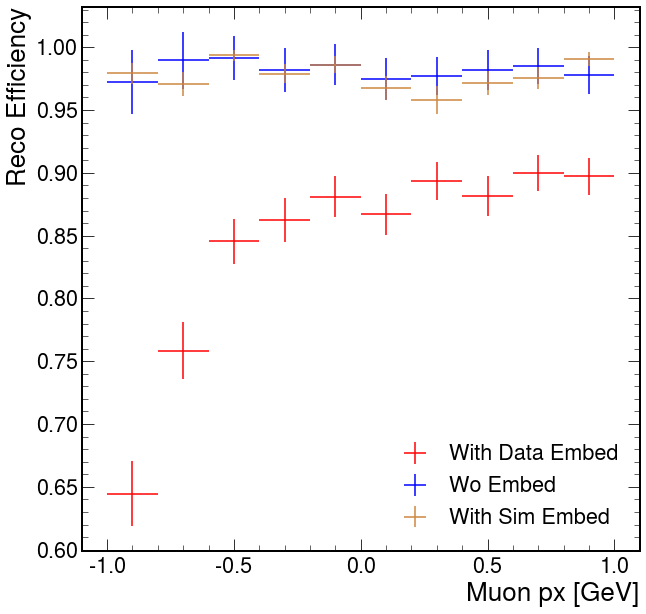

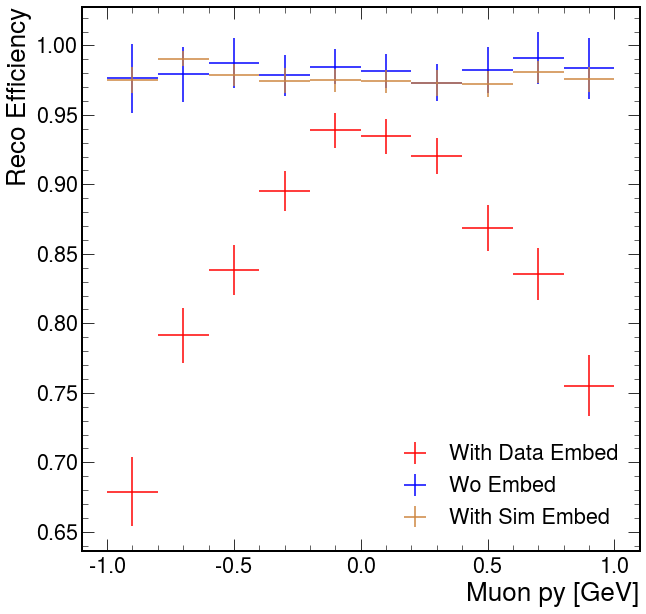

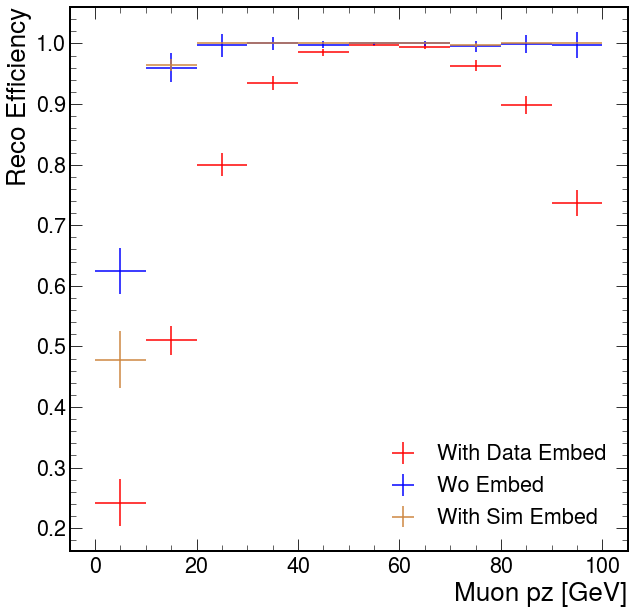

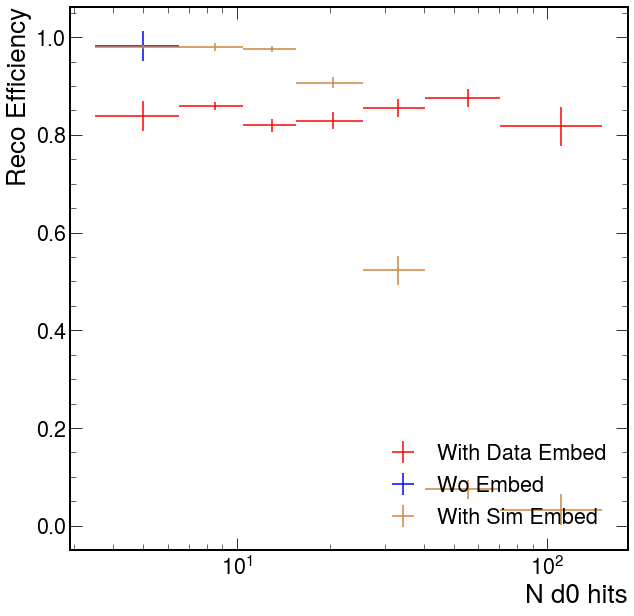

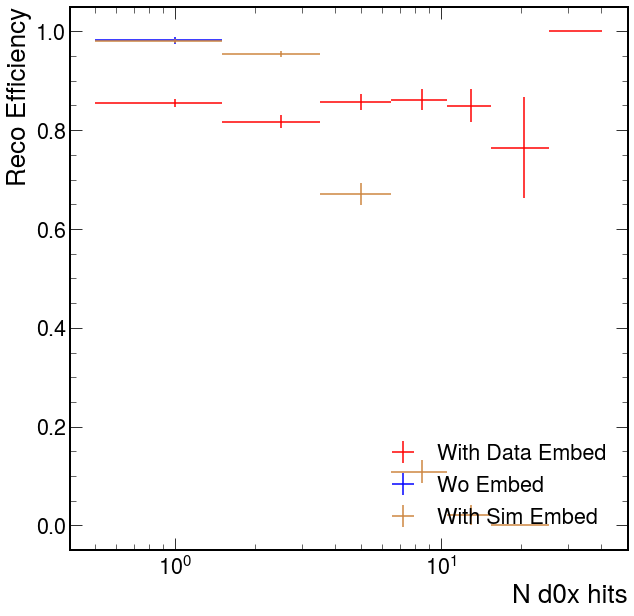

In [92]:
for pname in ['px', 'py', 'pz', 'd0', 'd0x']:
    eff_wembed, unc_wembed, bin_edges = calculateEff(events_wembed, pname)
    eff_woembed, unc_woembed, bin_edges = calculateEff(events_woembed, pname)
    eff_wembed_sim, unc_wembed_sim, bin_edges = calculateSimEff(events_wembed_sim, pname)

    x_centers = (bin_edges[:-1] + bin_edges[1:])/2.0
    x_errs = (bin_edges[1:] - bin_edges[:-1])/2.0


    plt.figure()
    plt.errorbar(x_centers, eff_wembed, unc_wembed, x_errs, label='With Data Embed', color='red', ls='none')
    plt.errorbar(x_centers, eff_woembed, unc_wembed, x_errs, label='Wo Embed', color='blue', ls='none')
    plt.errorbar(x_centers, eff_wembed_sim, unc_wembed_sim, x_errs, label='With Sim Embed', color='peru', ls='none')
    plt.ylabel('Reco Efficiency')
    plt.legend(loc='lower right')
    if pname in ['d0', 'd0x']:
        plt.xlabel(f'N {pname} hits')
        plt.xscale('log')
    else:
        plt.xlabel(f'Muon {pname} [GeV]')
    plt.savefig(f"plots/REco_Efficiency_{pname}.png")